<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/PyTorch/03_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recurrent** Neural Networks

Recurrent neural networks (RNNs) are a type of artificial neural network architecture designed to **handle sequential data**, where the order of elements matters.

Unlike traditional neural networks that process individual inputs independently, **RNNs have an internal "memory"** that allows them to remember information from previous inputs and use it to influence their predictions for the current input.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as dl

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cpu


# Step 1. Get the data

Using `ToTensor`, *will make you able to normalize, perform data augmenatation, etc.*

In [2]:
# hide the output
%%capture

# set the transform to -> ToTensor
transform = transforms.Compose([transforms.ToTensor()])

# Downlaod data
train = torchvision.datasets.MNIST('data', train=True,
                                   download=True, transform=transform)
test = torchvision.datasets.MNIST('data', train=False,
                                  download=True, transform=transform)

In [3]:
# Data Loader to select a batch from it
train_loader = dl(train, batch_size=64)
test_loader = dl(test, batch_size=64)

# Step 2. Vanilla RNN

A **pro tip** I took from [Andrada](https://www.kaggle.com/andradaolteanu) is to use print, *as many times as you can*, because it helps you understand what is happening.

In [4]:
class VanillaRNN(nn.Module):
  def __init__(self, batch_size, input_size, hidden_size, output_size):
    super(VanillaRNN, self).__init__()

    # RNN layer
    self.rnn = nn.RNN(input_size, hidden_size)

    # Fully connected layer
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, images, prints=False):
    if prints: print('Original Images Shape:', images.shape)

    # data augmentations
    images = images.permute(1, 0, 2)
    if prints: print('Permuted Images Shape', images.shape)

    # initalize hidden state with zeros
    hidden_state = torch.zeros(1, batch_size, hidden_size)
    if prints: print('Initial hidden state shape:', hidden_state.shape, '\n')

    # Creating RNN
    hidden_outputs, hidden_state = self.rnn(images, hidden_state)

    # Log probabilities
    out = self.fc(hidden_state)

    if prints:
      print('----hidden outputs shape:', hidden_outputs.shape, '\n' +
            '----final hidden state:', hidden_state.shape, '\n' +
            '----out shape:', out.shape, '\n')

    # Reshape out
    out = out.view(-1, output_size)
    if prints: print('Out Final Shape:', out.shape)

    return out

In [5]:
# Statics
batch_size = 64
input_size = 28
hidden_size = 150
output_size = 10

In [6]:
# take a sample

images_example, labels_example = next(iter(train_loader))
print('original image shape:', images_example.shape)

# Reshape
images_example = images_example.view(-1, 28, 28)
print('changed images shape:', images_example.shape, '\n' +
      'labels shape:', labels_example.shape, '\n')

original image shape: torch.Size([64, 1, 28, 28])
changed images shape: torch.Size([64, 28, 28]) 
labels shape: torch.Size([64]) 



In [7]:
# Creating a small model
model_example = VanillaRNN(batch_size, input_size,
                           hidden_size, output_size)
out = model_example(images_example, prints=True)

Original Images Shape: torch.Size([64, 28, 28])
Permuted Images Shape torch.Size([28, 64, 28])
Initial hidden state shape: torch.Size([1, 64, 150]) 

----hidden outputs shape: torch.Size([28, 64, 150]) 
----final hidden state: torch.Size([1, 64, 150]) 
----out shape: torch.Size([1, 64, 10]) 

Out Final Shape: torch.Size([64, 10])


In [8]:
# Understand Model Parameters
params = list(model_example.parameters())
print(f'There are {len(params)} parameters')
print('Parameters 0 - U:', params[0].shape, '\n' +
      'Parameters 1 - W:', params[1].shape, '\n' +
      'Parameters 2 - Bias:', params[2].shape, '\n' +
      'Parameters 3 - Bias:', params[3].shape, '\n' +
      'Parameters 4 - Forward weights:', params[4].shape, '\n' +
      'Parameters 5 - Predictions:', params[5].shape, '\n')

There are 6 parameters
Parameters 0 - U: torch.Size([150, 28]) 
Parameters 1 - W: torch.Size([150, 150]) 
Parameters 2 - Bias: torch.Size([150]) 
Parameters 3 - Bias: torch.Size([150]) 
Parameters 4 - Forward weights: torch.Size([10, 150]) 
Parameters 5 - Predictions: torch.Size([10]) 



## **Pre**defined functions

In [13]:
def get_accuracy(out, actual_labels, batchSize):
  preds = out.max(dim=1)[1]
  correct = (preds == actual_labels).sum().item()
  acc = correct/batch_size
  return acc

In [14]:
def train_network(model, train_data, test_data,
                  batchSize=64, num_epochs=1, learning_rate=0.001):
  print('Get data read...')

  train_loader = dl(dataset=train_data, batch_size=batchSize,
                    shuffle=True, drop_last=True)
  test_loader = dl(dataset=test_data, batch_size=batchSize,
                   shuffle=True, drop_last=True)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  print('Training started...')
  for epoch in range(num_epochs):

    train_loss = 0
    train_acc = 0

    model.train()

    for i, (images, labels) in enumerate(train_loader):

      images = images.view(-1, 28, 28)
      out = model(images)

      optimizer.zero_grad()

      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_acc += get_accuracy(out, labels, batchSize)

    print(f'TRAIN | Epoch: {epoch+1}/{num_epochs} | ' +
          f'Loss: {train_loss/i:.2f} | Accuracy: {train_acc/i:.2f}')

  ### ===== TESTING ====== ###
  print('Testing Started...')

  test_acc = 0
  model.eval()

  for i, (images, labels) in enumerate(test_loader):
    images = images.view(-1, 28, 28)
    out = model(images)
    test_acc += get_accuracy(out, labels, batchSize)

  print(f'TEST | Average Accuracy per {i} Loaders: {test_acc/i:.3f}')

## Training ...

In [15]:
# statics
batch_size = 64
input_size = 28
hidden_size = 150
output_size = 10

# instantiate the model
vanilla_rnn = VanillaRNN(batch_size, input_size, hidden_size, output_size)

# train
train_network(vanilla_rnn, train, test, num_epochs=10)

Get data read...
Training started...
TRAIN | Epoch: 1/10 | Loss: 0.72 | Accuracy: 0.77
TRAIN | Epoch: 2/10 | Loss: 0.30 | Accuracy: 0.91
TRAIN | Epoch: 3/10 | Loss: 0.22 | Accuracy: 0.94
TRAIN | Epoch: 4/10 | Loss: 0.18 | Accuracy: 0.95
TRAIN | Epoch: 5/10 | Loss: 0.16 | Accuracy: 0.96
TRAIN | Epoch: 6/10 | Loss: 0.15 | Accuracy: 0.96
TRAIN | Epoch: 7/10 | Loss: 0.14 | Accuracy: 0.96
TRAIN | Epoch: 8/10 | Loss: 0.13 | Accuracy: 0.97
TRAIN | Epoch: 9/10 | Loss: 0.12 | Accuracy: 0.97
TRAIN | Epoch: 10/10 | Loss: 0.11 | Accuracy: 0.97
Testing Started...
TEST | Average Accuracy per 155 Loaders: 0.965


# Multilayer RNNs

In [23]:
class MultilayerRNN(nn.Module):
  def __init__(self, input_size, hidden_size, layer_size,
               output_size, relu=True):
    super(MultilayerRNN, self).__init__()
    self.input_size, self.hidden_size = input_size, hidden_size
    self.output_size = output_size
    self.layer_size = layer_size

    if relu:
      self.rnn = nn.RNN(input_size, hidden_size, layer_size,
                        batch_first=True, nonlinearity='relu')
    else:
      self.rnn = nn.RNN(input_size, hidden_size, layer_size,
                        batch_first=True, nonlinearity='tanh')

    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, images, prints=False):
    if prints: print('image shape', images.detach().numpy().shape)

    hidden_state = torch.zeros(self.layer_size, images.size(0), hidden_size)
    hidden_state = hidden_state.requires_grad_()
    if prints: print('Hidden state shape',
                     hidden_state.detach().numpy().shape)

    # compute RNN
    output, last_hidden_state = self.rnn(images, hidden_state.detach())
    if prints: print('RNN output shape', output.detach().numpy().shape, '\n' +
                     'RNN last hidden state shape',
                     last_hidden_state.detach().numpy().shape)

    # compute Fully connected layer
    output = self.fc(output[:, -1, :])
    if prints: print('Fully connected shape:', output.detach().numpy().shape)

    return output


In [24]:
# === statics ========
batch_size = 64
input_size = 28
hidden_size = 100      # neurons
layer_size = 2         # layers
output_size = 10
# =================

In [25]:
multilayer_rnn = MultilayerRNN(input_size, hidden_size, layer_size,
                               output_size, relu=False)

# === TRAIN ====
train_network(multilayer_rnn, train, test, num_epochs=10)

Get data read...
Training started...
TRAIN | Epoch: 1/10 | Loss: 0.70 | Accuracy: 0.77
TRAIN | Epoch: 2/10 | Loss: 0.29 | Accuracy: 0.92
TRAIN | Epoch: 3/10 | Loss: 0.21 | Accuracy: 0.94
TRAIN | Epoch: 4/10 | Loss: 0.18 | Accuracy: 0.95
TRAIN | Epoch: 5/10 | Loss: 0.16 | Accuracy: 0.96
TRAIN | Epoch: 6/10 | Loss: 0.14 | Accuracy: 0.96
TRAIN | Epoch: 7/10 | Loss: 0.14 | Accuracy: 0.96
TRAIN | Epoch: 8/10 | Loss: 0.15 | Accuracy: 0.96
TRAIN | Epoch: 9/10 | Loss: 0.14 | Accuracy: 0.96
TRAIN | Epoch: 10/10 | Loss: 0.11 | Accuracy: 0.97
Testing Started...
TEST | Average Accuracy per 155 Loaders: 0.965


# LSTM

In [26]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, layer_size,
               output_size, bidirectional=True):
    super(LSTM, self).__init__()
    self.input_size, self.hidden_size = input_size, hidden_size
    self.layer_size, self.output_size = layer_size, output_size
    self.bidirectional = bidirectional

    # 1. LSTM model
    self.lstm = nn.LSTM(input_size, hidden_size, layer_size,
                        batch_first=True, bidirectional=bidirectional)

    # 2. Fully connected layer
    if bidirectional: self.layer = nn.Linear(hidden_size*2, output_size)
    else: self.layer = nn.Linear(hidden_size, output_size)

  def forward(self, images):
    if self.bidirectional:
      hidden_state = torch.zeros(self.layer_size*2,
                                 images.size(0), self.hidden_size)
      cell_state = torch.zeros(self.layer_size*2,
                               images.size(0), self.hidden_size)

    else:
      hidden_state = torch.zeros(self.layer_size,
                                 images.size(0), self.hidden_size)
      cell_state = torch.zeros(self.layer_size,
                               images.size(0), self.hidden_size)

    # LSTM
    output, (last_hidden_state, last_cell_state) = self.lstm(images,
                                                             (hidden_state,
                                                              cell_state))
    # RESHAPE
    output = output[:, -1, :]

    # fully connected
    output = self.layer(output)

    return output

In [27]:
# ==== STATICS ====
batch_size = 64
input_size = 28
hidden_size = 100
layer_size = 2
output_size = 10

# Instantiate the model
# We'll use TANH as our activation function
lstm_rnn = LSTM(input_size, hidden_size, layer_size, output_size)

# ==== TRAIN ====
train_network(lstm_rnn, train, test, num_epochs=10)

Get data read...
Training started...
TRAIN | Epoch: 1/10 | Loss: 0.44 | Accuracy: 0.86
TRAIN | Epoch: 2/10 | Loss: 0.13 | Accuracy: 0.96
TRAIN | Epoch: 3/10 | Loss: 0.09 | Accuracy: 0.97
TRAIN | Epoch: 4/10 | Loss: 0.07 | Accuracy: 0.98
TRAIN | Epoch: 5/10 | Loss: 0.06 | Accuracy: 0.98
TRAIN | Epoch: 6/10 | Loss: 0.05 | Accuracy: 0.99
TRAIN | Epoch: 7/10 | Loss: 0.04 | Accuracy: 0.99
TRAIN | Epoch: 8/10 | Loss: 0.04 | Accuracy: 0.99
TRAIN | Epoch: 9/10 | Loss: 0.03 | Accuracy: 0.99
TRAIN | Epoch: 10/10 | Loss: 0.03 | Accuracy: 0.99
Testing Started...
TEST | Average Accuracy per 155 Loaders: 0.993


# Confusion Matrix


Text(0.5, 1.0, 'Confusion Matrix')

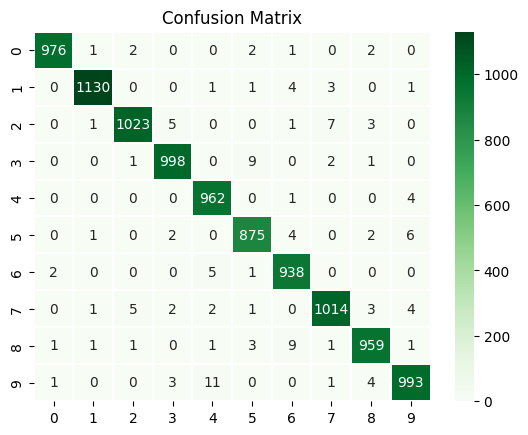

In [29]:
import sklearn.metrics as metrics

def confusion_matrix(model, test_data):
  torch.no_grad() # disable gradient computing
  model.eval()

  preds, actuals = [], []

  for image, label in test:
    image = image.view(-1, 28, 28)
    out = model(image)

    pred = torch.max(out, dim=1)[1].item()
    preds.append(pred)
    actuals.append(label)

  return metrics.confusion_matrix(preds, actuals)


# get the plot
sns.heatmap(confusion_matrix(lstm_rnn, test), linewidths=0.1,
            annot=True, fmt='g', cmap='Greens')
plt.title('Confusion Matrix')

# **References:**
* Misra Turp. 2022. [Basics of Recurrent Neural Networks](https://youtu.be/M6-AIQnB4_Q?si=TrBq7jsb6L8OMnFV), [LSTM & GRUs](https://youtu.be/E4c_bom0_6Y?si=qGaQ3FYlpRphiIan). YouTube.
* Andrada. 2020. [PyTorch RNNs and LSTM](https://www.kaggle.com/code/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99). Kaggle.